In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from time import sleep
from sklearn.metrics import confusion_matrix
sns.color_palette("pastel")
sns.set_style('dark')
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import numpy as np
from Shapley import ShapNN
from DShap import DShap
import matplotlib.pyplot as plt
import sklearn
from shap_utils import *
%matplotlib inline
MEM_DIR = './'
import pandas as pd
import time
import numpy as np
from sklearn.utils import shuffle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df = pd.read_csv('diabetes.csv')
print()
df = df.sample(frac = 1)


In [12]:
import numpy as np
from tqdm import tqdm


def get_true_KNN(x_trn, x_tst):
    N = x_trn.shape[0]
    N_tst = x_tst.shape[0]
    x_tst_knn_gt = np.zeros((N_tst, N))
    for i_tst in tqdm(range(N_tst)):
        dist_gt = np.zeros(N)
        for i_trn in range(N):
            dist_gt[i_trn] = np.linalg.norm(x_trn[i_trn, :] - x_tst[i_tst, :], 2)
        x_tst_knn_gt[i_tst, :] = np.argsort(dist_gt)
    return x_tst_knn_gt.astype(int)


def compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K):
    N = x_trn.shape[0]
    N_tst = x_tst_knn_gt.shape[0]
    sp_gt = np.zeros((N_tst, N))
    for j in tqdm(range(N_tst)):
        sp_gt[j, x_tst_knn_gt[j, -1]] = (y_trn[x_tst_knn_gt[j, -1]] == y_tst[j]) / N
        for i in np.arange(N - 2, -1, -1):
            sp_gt[j, x_tst_knn_gt[j, i]] = sp_gt[j, x_tst_knn_gt[j, i + 1]] + \
                                           (int(y_trn[x_tst_knn_gt[j, i]] == y_tst[j]) -
                                            int(y_trn[x_tst_knn_gt[j, i + 1]] == y_tst[j])) / K * min([K, i + 1]) / (
                                                       i + 1)
    return sp_gt

In [18]:
pure_vals = []
impure_vals = []
for i in (range(100)):
    df = df.sample(frac = 1)
    y = df['Outcome']
    x = df.drop('Outcome', axis = 1)
    x_pure = np.asarray(x)[0:300, :]
    y_pure = np.asarray(y)[0:300]

    x_with_noise_pre_noise = np.asarray(x)[300:600, :]
    noise = np.random.normal(0, 1000, x_with_noise_pre_noise.shape)
    x_with_noise = x_with_noise_pre_noise + noise
    y_with_noise = np.asarray(y)[300:600]

    x_trn = np.asarray(x)[600:, :]
    y_trn = np.asarray(y)[600:]
    


    
    
    x_tst = np.concatenate((x_pure, x_with_noise), axis = 0)
    y_tst = np.concatenate((y_pure, y_with_noise), axis = 0)




    K = 1
    x_tst_knn_gt = get_true_KNN(x_trn, x_tst)
    sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K)
    




    

    pure_vals.append((sum(np.sum(sp_gt, axis = 1)[0:300])/300))
    impure_vals.append(sum(np.sum(sp_gt, axis = 1)[300:600])/300)

    

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 953.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 928.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 959.79it/s]


In [19]:
print(np.mean(pure_vals))
print(np.mean(impure_vals))

0.6690666666666667
0.4886000000000001


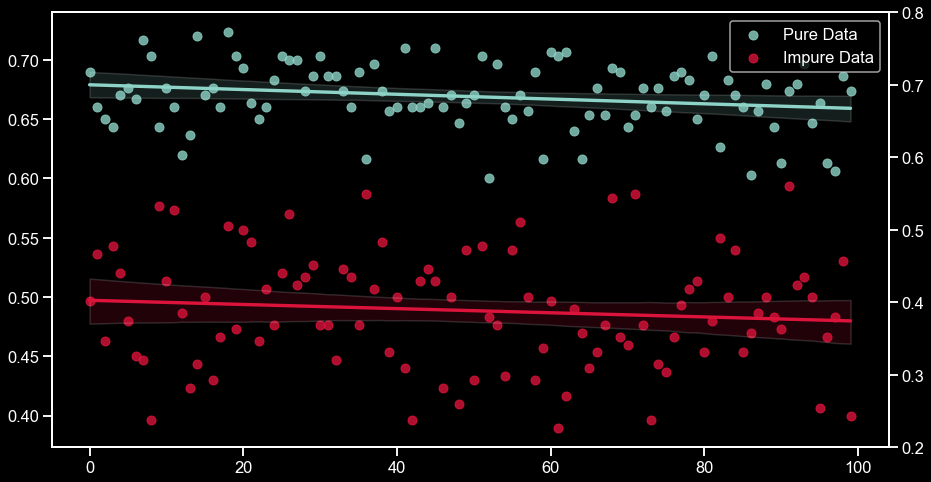

In [24]:
xax = np.arange(100)
plt.figure(figsize=(15, 8))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
ax = sns.regplot(x=xax, y=pure_vals, label= "Pure Data")
ax2 = ax.twinx()
sns.regplot(x=xax, y=impure_vals, marker='o', color='crimson', ax=ax, label = "Impure Data")
plt.ylim(0.2,0.8)
ax.legend(loc="best")
plt.show()
